This is a notebook that use the FLOCELLID_taxa.tab file in the WGS folder to generate ncbi hit plot for the four flowcells.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import product

In [2]:
BASEDIR = '/home/yiheng/analysis/WGS'

In [3]:
# get the summary dataframe
FC1_taxa = os.path.join(BASEDIR, 'run1_taxa.tab')
FC2_taxa = os.path.join(BASEDIR, 'run2_taxa.tab')
FC3_taxa = os.path.join(BASEDIR, 'FAH05432_taxa.tab')
FC4_taxa = os.path.join(BASEDIR, 'FAH05731_taxa.tab')

FC1_taxa_df = pd.read_csv(FC1_taxa, sep = '\t')
FC2_taxa_df = pd.read_csv(FC2_taxa, sep = '\t')
FC3_taxa_df = pd.read_csv(FC3_taxa, sep = '\t')
FC4_taxa_df = pd.read_csv(FC4_taxa, sep = '\t')

In [4]:
joint_taxa_df = pd.concat([FC1_taxa_df,  
                           FC2_taxa_df,
                           FC3_taxa_df,
                           FC4_taxa_df], ignore_index=True)

In [5]:
joint_taxa_df

,read_id,barcode_arrangement,staxids_nt,superkingdom,phylum,class,order,family,genus,species,Flowcell
0,03fe0b0a-1fb6-4102-909b-443d842f1fc9,barcode01,43300,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified,Cloning vector lambda TXF97,run1
1,ea8614ad-f6b7-4cf8-a584-4b784b761dd2,barcode01,33069,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas viridiflava,run1
2,74bf46de-9d7f-4d5e-8422-4395d4d36572,barcode01,1276538,Eukaryota,Ascomycota,Dothideomycetes,Capnodiales,Mycosphaerellaceae,Zymoseptoria,Zymoseptoria tritici,run1
3,e98f757d-647b-4dfd-91d7-694c7b0ab12a,barcode01,1047171,Eukaryota,Ascomycota,Dothideomycetes,Capnodiales,Mycosphaerellaceae,Zymoseptoria,Zymoseptoria tritici,run1
4,2149e363-9367-4d32-b3af-996b77a5e99a,barcode01,4565,Eukaryota,Streptophyta,Liliopsida,Poales,Poaceae,Triticum,Triticum aestivum,run1
5,40eae7a5-f0b0-4a73-bc4f-3f191a2110b1,barcode01,102285,Eukaryota,Platyhelminthes,Cestoda,Cyclophyllidea,Hymenolepididae,Hymenolepis,Hymenolepis nana,run1
6,7cf0383a-5007-4dbe-8f31-0c8b649a65f0,barcode01,1276538.0,Eukaryota,Ascomycota,Dothideomycetes,Capnodiales,Mycosphaerellaceae,Zymoseptoria,Zymoseptoria tritici,run1
7,1f4b2d5d-cc37-4418-a8cc-20ee0b1bff2d,barcode01,1047171,Eukaryota,Ascomycota,Dothideomycetes,Capnodiales,Mycosphaerellaceae,Zymoseptoria,Zymoseptoria tritici,run1
8,9ae4bf5f-b5c0-4369-aaa4-4e77bb44bd33,barcode01,1660073.0,Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,Campylobacter sp. RM6137,run1
9,873f3993-5807-460c-85b0-986a24f57f5b,barcode01,236234.0,Eukaryota,Ascomycota,Dothideomycetes,Botryosphaeriales,Botryosphaeriaceae,Diplodia,Diplodia corticola,run1


In [6]:
#Defines a function to make manual adjustments to the NCBI taxonomic sorting
def manually_adjust_ncbi_taxonomy(rank_select, entry_select, ranks_to_edit, new_entry):
    """Select dataframe entries to edit by a specific rank (rank_select) 
    and entry related to that rank (entry_select), 
    provide a list of ranks to edit for those selected entries (ranks_to_edit),
    replace these ranks with a new entry (new_entry)"""
    if entry_select in list(joint_taxa_df[rank_select].unique()):
        selection = (joint_taxa_df[rank_select] == entry_select)
        selected_tax_ranks = ranks_to_edit
        for ranks in selected_tax_ranks:
            joint_taxa_df[ranks][selection] = new_entry

In [7]:
manually_adjust_ncbi_taxonomy('species', 
                            'Cloning vector lambda TXF97', 
                            ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus'], 
                            'Cloning vector lambda TXF97')

manually_adjust_ncbi_taxonomy('superkingdom', 
                            'Viruses', 
                            ['phylum', 'class'], 
                            'dsDNA viruses, no RNA stage')

In [8]:
#count pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='order', 
                                            index=rank, 
                                            columns='barcode_arrangement', 
                                            aggfunc='count', 
                                            fill_value=0, 
                                            margins=True)
    pivot_table.columns.name = None
    return pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [9]:
generate_ncbi_taxonomy_pivot(joint_taxa_df, 'family','barcode04',20)

,barcode01,barcode02,barcode03,barcode04,barcode05,All
family,,,,,,
All,2517.0,4818.0,363.0,2235.0,2465.0,12398.0
Pseudomonadaceae,1800.0,2547.0,152.0,1335.0,1494.0,7328.0
Pleosporaceae,59.0,500.0,45.0,191.0,266.0,1061.0
Sphingomonadaceae,2.0,299.0,6.0,94.0,108.0,509.0
Poaceae,20.0,39.0,27.0,65.0,58.0,209.0
Enterobacteriaceae,78.0,84.0,18.0,61.0,15.0,256.0
Hymenobacteraceae,1.0,124.0,4.0,54.0,37.0,220.0
Mycosphaerellaceae,13.0,195.0,3.0,51.0,41.0,303.0
Microbacteriaceae,7.0,260.0,15.0,42.0,47.0,371.0


In [10]:
# % pivot table of dataframe with taxonomic columns: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_ncbi_taxonomy_pivot_pc(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank %, sorted ascending by bcs"""
    pivot_table_pc = tax_df.pivot_table(values='order', 
                                            index=rank, 
                                            columns='barcode_arrangement', 
                                            aggfunc='count', 
                                            fill_value=0, 
                                            margins=True)
    pivot_table_pc.columns.name = None
    
    for brcs in pivot_table_pc.columns:
        pivot_table_pc[str(brcs) + '%'] = pivot_table_pc[brcs].apply(lambda x: (x / pivot_table_pc[brcs].loc['All'])*100)
    for brcs in pivot_table_pc.columns:
        if '%' not in brcs:
            pivot_table_pc.drop(brcs, axis=1, inplace=True)
    pivot_table_pc.drop('All', axis=0, inplace=True)

    pivot_table_pc2 = pivot_table_pc.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return pivot_table_pc2.applymap(lambda x: '%.3f' % x).head(n=num)

In [11]:
generate_ncbi_taxonomy_pivot_pc(joint_taxa_df, 'species', 'barcode04', 20)

,barcode01%,barcode02%,barcode03%,barcode04%,barcode05%,All%
species,,,,,,
Pseudomonas syringae,56.297,35.596,10.193,40.984,25.355,37.990
Pseudomonas viridiflava,1.112,3.342,5.234,7.114,2.961,3.549
Alternaria alternata,1.629,7.721,7.989,6.398,7.870,6.283
Pseudomonas poae,6.595,6.932,9.642,6.219,20.284,9.469
Escherichia coli,0.675,1.225,4.683,2.371,0.406,1.258
Zymoseptoria tritici,0.477,3.923,0.826,2.148,1.501,2.331
Hymenobacter sp. PAMC 26554,0.000,1.494,0.275,1.566,0.974,1.065
Sphingomonas taxi,0.000,1.847,0.551,1.521,1.217,1.250
Triticum aestivum,0.318,0.208,4.959,1.342,1.704,0.871


In [12]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(joint_taxa_df['barcode_arrangement'].unique())
no_of_subplots = len(ncbiblast_barcodes)+1

In [13]:
#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))

In [15]:
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank):
    labels = ''
    labels = tuple(generate_ncbi_taxonomy_pivot_pc(joint_taxa_df, rank, bcs, 10)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_ncbi_taxonomy_pivot_pc(joint_taxa_df, rank, bcs, 10)[bcs + '%']])
    
    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=get_color(2*ax_ind2 + ax_ind1))
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    ax[ax_ind1, ax_ind2].set_xlabel('% Total Reads Hitting NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, 110, 10))
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, ncbiblast_barcodes):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank)    

    if len(list(joint_taxa_df['barcode_arrangement'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting NCBI Database - % By ' + str(search_rank).title() + ' By Barcode', 
             fontsize='x-large',
             y=1.02,
             fontweight="bold")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
    plt.tight_layout()
    
    plt.savefig(BASEDIR + '/figures/' + 'figure3.png', bbox_inches='tight')
    plt.show()
            


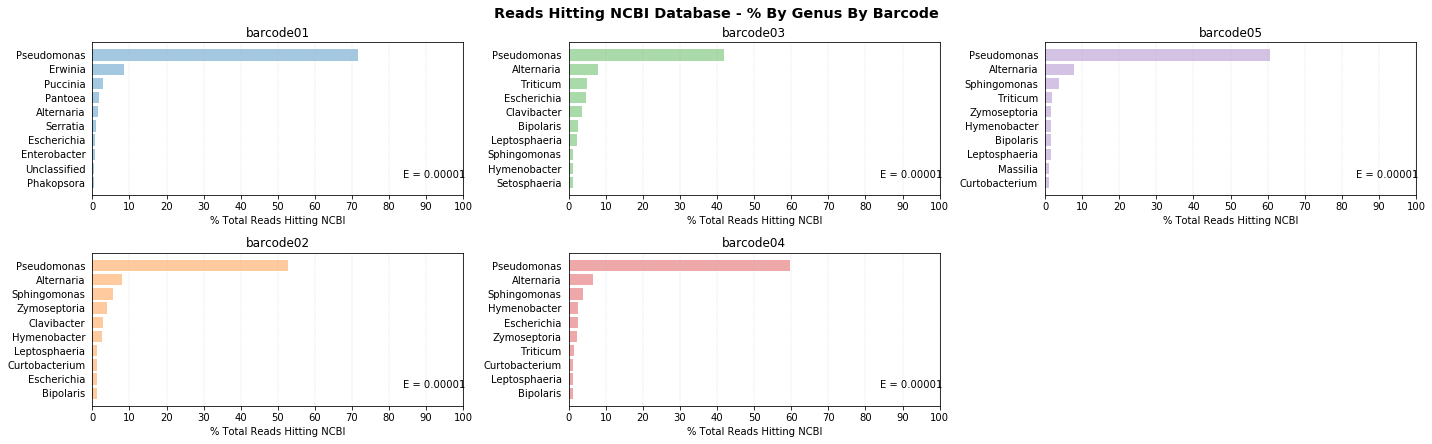

In [19]:
fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
generateTaxSubplots('genus')